In [77]:
import sys
import numpy             as np
import tensorflow        as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import gudhi.representations as gdr
import gudhi.tensorflow.perslay as gdtf

In this notebook, we illustrate the various options of the ${\rm PersLay}$ layer that is implemented in Gudhi. The layer ${\rm PersLay}$ is a neural network layer that can learn persistence diagram vectorizations during the classifier training phase (in supervised machine learning). It has four main components (see [the associated paper](http://proceedings.mlr.press/v108/carriere20a.html)): one is a weight function $w$ for persistence diagram points, one is a transformation function $\phi:\mathbb{R}^2\to\mathbb{R}^n$, one is a permutation-invariant operation ${\rm pop}$, and one is a post-processing function $\rho:\mathbb{R}^n\to\mathbb{R}^d$. The layer ${\rm PersLay}:\mathcal D \to \mathbb{R}^n$ is then computed on a persistence diagram $D$ as:

$${\rm PersLay}(D):=\rho({\rm pop}(\{w(p)\cdot\phi(p)\,:\, p\in D\}))$$

In order to illustrate this, let's first define two simple persistence diagrams.

In [78]:
diagrams = [np.array([[0.,4.],[1.,2.],[3.,8.],[6.,8.]]), np.array([[3.,6.],[4.,5.]])]

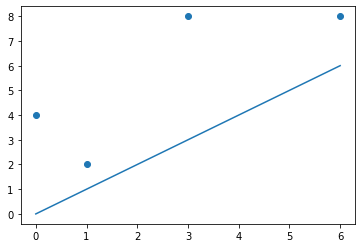

In [79]:
plt.scatter(diagrams[0][:,0], diagrams[0][:,1])
plt.plot([0.,6.],[0.,6.])
plt.show()

In order to easily design the ${\rm PersLay}$ parameters, let's rescale the coordinates of the points in the persistence diagrams in the unit square.

In [80]:
diagrams = gdr.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())]).fit_transform(diagrams)

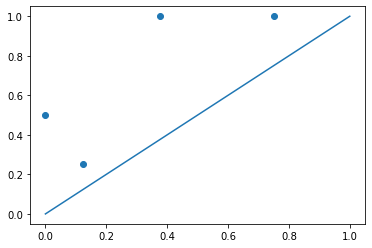

In [82]:
plt.scatter(diagrams[0][:,0], diagrams[0][:,1])
plt.plot([0.,1.],[0.,1.])
plt.show()

The layer ${\rm PersLay}$ is implemented in TensorFlow, so we now convert the persistence diagrams into ragged tensors (since persistence diagrams do not necessarily have the same numbers of points, so we cannot use tensors with a fixed shape).

In [83]:
diagrams = tf.concat([
    tf.RaggedTensor.from_tensor(tf.constant(diagrams[0][None,:], dtype=tf.float32)),
    tf.RaggedTensor.from_tensor(tf.constant(diagrams[1][None,:], dtype=tf.float32))
], axis=0)

In [84]:
print(diagrams)

<tf.RaggedTensor [[[0.0, 0.5],
  [0.125, 0.25],
  [0.375, 1.0],
  [0.75, 1.0]]  , [[0.375, 0.75],
                   [0.5, 0.625]] ]>


We are now ready! The class `gudhi.tensorflow.perslay.PersLay` has four arguments which correspond to the parameters described above: `phi`, `weight`, `perm_op` and `rho`. All can be initialized with TensorFlow functions, but we also provide a few predefined options. 

Depending on the parameters used, one can reproduce known vectorizations from the TDA literature, which we showcase below. Note that the `GradientTape` function shows that all our operations are differentiable, but this is just for fun, we do not use these gradients afterwards ;-)  

The most usual vectorization is the persistence landscape, which can be obtained with `PowerPerslayWeight`, `TentPerslayPhi` and `'top-k'` operation. We do not post-process the landscape in this example so `rho` is simply `tf.identity`. Finally we show the gradient w.r.t. to the samples on which the lanscape is evaluated.

In [90]:
with tf.GradientTape() as tape:
    
    rho = tf.identity 
    phi = gdtf.TentPerslayPhi(np.array(np.arange(-1.,2.,.001), dtype=np.float32))
    weight = gdtf.PowerPerslayWeight(1.,0.)
    perm_op = 'top3'
    
    perslay = gdtf.Perslay(phi=phi, weight=weight, perm_op=perm_op, rho=rho)
    vectors = perslay(diagrams)
    
print('Gradient is ', tape.gradient(vectors, phi.samples))

Gradient is  tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(3000,), dtype=float32)


Let's visually check that ${\rm PersLay}$ actually computed something that looks like a landscape.

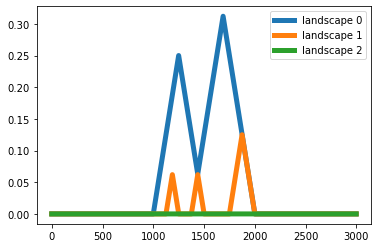

In [91]:
plt.figure()
vectors = np.reshape(vectors[0,:], [-1, 3])
for k in range(3):
    plt.plot(vectors[:,k], linewidth=5., label='landscape ' + str(k))
plt.legend()
plt.show()

A variation of the persistence landscape is the Betti curve, which sums flat functions instead of tents for the persistence diagram points.

In [94]:
with tf.GradientTape() as tape:
    
    rho = tf.identity 
    phi = gdtf.FlatPerslayPhi(np.array(np.arange(-1.,2.,.001), dtype=np.float32), 50.)
    weight = gdtf.PowerPerslayWeight(1.,0.)
    perm_op = tf.math.reduce_sum
    
    perslay = gdtf.Perslay(phi=phi, weight=weight, perm_op=perm_op, rho=rho)
    vectors = perslay(diagrams)
    
print('Gradient is ', tape.gradient(vectors, phi.samples))

Gradient is  tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(3000,), dtype=float32)


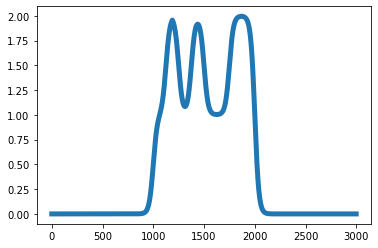

In [95]:
plt.figure()
plt.plot(vectors[0,:], linewidth=5.)
plt.show()

Another standard vectorization is the persistence image, which can be obtained with `PowerPerslayWeight`, `GaussianPerslayPhi` and `tf.math.reduce_sum` operation. Since the output is an image, we use a convolutional layer to post-process the output with $\rho$ in this example. Finally we show the gradient w.r.t. to the variance of the persistence image.

In [96]:
with tf.GradientTape() as tape:
    
    rho = tf.keras.layers.Conv2D(3,5)
    phi = gdtf.GaussianPerslayPhi((100, 100), ((-.5, 1.5), (-.5, 1.5)), .1)
    weight = gdtf.PowerPerslayWeight(1.,2.)
    perm_op = tf.math.reduce_sum
    
    perslay = gdtf.Perslay(phi=phi, weight=weight, perm_op=perm_op, rho=rho)
    vectors = perslay(diagrams)
    
print('Gradient is ', tape.gradient(vectors, phi.variance))

Gradient is  tf.Tensor(-0.32421875, shape=(), dtype=float32)


Again, let's visually check that ${\rm PersLay}$ actually computed something that looks like an image.

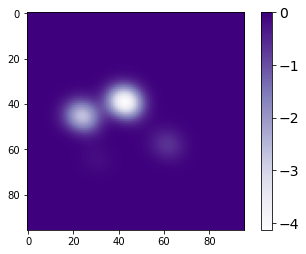

In [97]:
plt.figure()
plt.imshow(np.flip(vectors[0,:,:,0],0), cmap="Purples")
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

Gudhi also provides other weight functions: one is a mixture of Gaussian functions `GaussianMixturePerslayWeight`, and the other simply defines the function from its values on a grid `GridPerslayWeight`.

Let's see `GaussianMixturePerslayWeight` first.

In [98]:
with tf.GradientTape() as tape:
    
    rho = tf.identity
    phi = gdtf.GaussianPerslayPhi((100, 100), ((-.5, 1.5), (-.5, 1.5)), .05)
    weight = gdtf.GaussianMixturePerslayWeight(np.array([[0.],[.25],[1],[1]], dtype=np.float32))
    perm_op = tf.math.reduce_sum
    
    perslay = gdtf.Perslay(phi=phi, weight=weight, perm_op=perm_op, rho=rho)
    vectors = perslay(diagrams)

We visualize the mixture of Gaussians below, with persistence diagram points displayed on top in red.

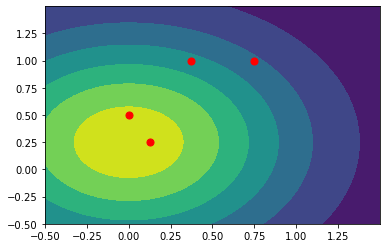

In [99]:
means = weight.W[:2,:].numpy()
varis = weight.W[2:,:].numpy()
x, y = np.arange(-.5, 1.5, .001), np.arange(-.5, 1.5, .001)
xx, yy = np.meshgrid(x, y)
z = np.zeros(xx.shape)
for idx_g in range(means.shape[1]):
    z += np.exp(-((xx-means[0,idx_g])**2 * (varis[0,idx_g])**2 + (yy-means[1,idx_g])**2 * (varis[1,idx_g])**2 ))
plt.contourf(xx, yy, z)
plt.scatter(diagrams[0][:,0], diagrams[0][:,1], s=50, color="red")
plt.show()

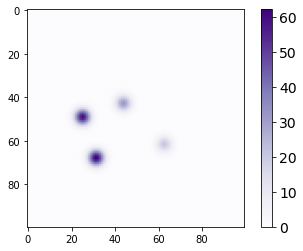

In [100]:
plt.figure()
plt.imshow(np.flip(vectors[0,:,:,0],0), cmap="Purples")
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

Let's now look at `GridPerslayWeight` (with function values on the grid initialized randomly).

In [101]:
with tf.GradientTape() as tape:
    
    rho = tf.identity
    phi = gdtf.GaussianPerslayPhi((100, 100), ((-.5, 1.5), (-.5, 1.5)), .1)
    weight = gdtf.GridPerslayWeight(np.array(
        np.random.uniform(size=[100,100]),dtype=np.float32),((-0.01, 1.01),(-0.01, 1.01)))
    perm_op = tf.math.reduce_sum
    
    perslay = gdtf.Perslay(phi=phi, weight=weight, perm_op=perm_op, rho=rho)
    vectors = perslay(diagrams)

We can visualize the weight function values on the grid as an image.

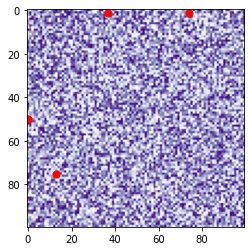

In [102]:
W = np.flip(weight.grid.numpy(), 0)
plt.figure()
plt.imshow(W, cmap="Purples", zorder=1)
((xm,xM),(ym,yM)) = weight.grid_bnds
[xs, ys] = weight.grid.shape
plt.scatter([int(xs*(x-xm)/(xM-xm)) for x in diagrams[0][:,0]], 
            [ys-int(ys*(y-ym)/(yM-ym)) for y in diagrams[0][:,1]], 
            s=50, color="red", zorder=2)
plt.show()

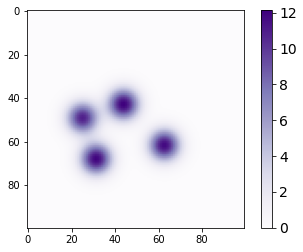

In [103]:
plt.figure()
plt.imshow(np.flip(vectors[0,:,:,0],0), cmap="Purples")
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()